In [218]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression,HuberRegressor, Lasso, Ridge, ElasticNet
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error

In [156]:
train_df=pd.read_csv('pre_processed.csv')

In [157]:
# prepare predictor and response variables
train_df= train_df.loc[train_df['saleprice']<700000] # remove outliers of 2 observations
y=train_df.iloc[:,-1:]


X=train_df.iloc[:,:-2]
X_label=train_df.iloc[:,0:1]
X=X.drop('Id',axis=1)

print(X.shape)
print(y.shape)

(1456, 19)
(1456, 1)


In [158]:
train_df.iloc[:,-1:]

,log_saleprice
0,12.247694
1,12.109011
2,12.317167
3,11.849398
4,12.429216
...,...
1453,12.072541
1454,12.254863
1455,12.493130
1456,11.864462


<h3> Checking Target variable distribution <h>

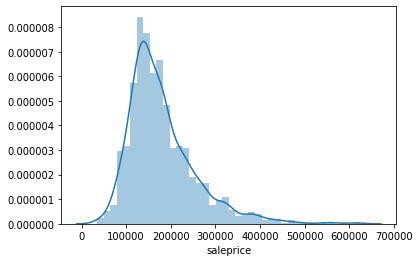

In [159]:
sb.distplot(train_df['saleprice'])

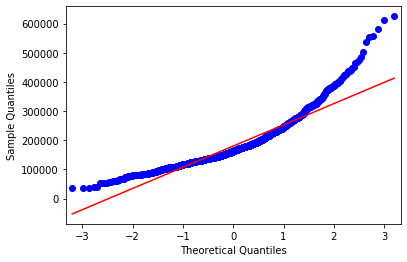

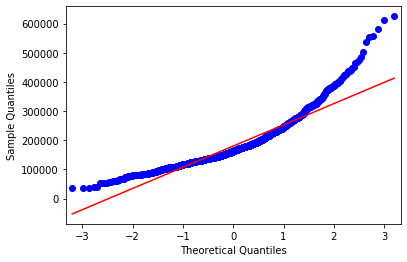

In [160]:
# checking skewness of target variable
sm.qqplot(train_df['saleprice'],line='r',fit=False)

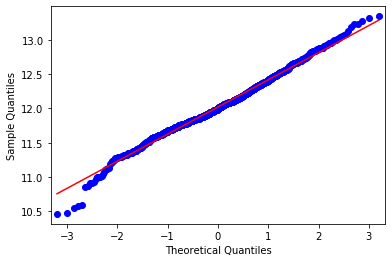

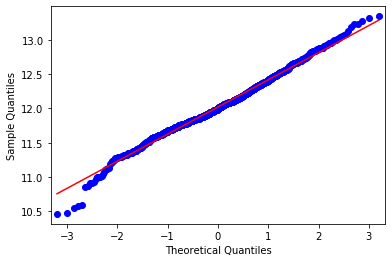

In [161]:
# log transform to reduce skewness of target variable
sm.qqplot(y['log_saleprice'],line='r',fit=False)

<h3> Train and Test split the data <h>

In [162]:
# Splitting the dataset into the Training set and Test set

# Manually slip the data
# np.random.seed(1)
# testIdxes = np.random.choice(range(1458), size= 290, replace=False)
# trainIdxes = list(set(range(1458)) - set(testIdxes))

# X_train = X.iloc[trainIdxes]
# X_test  = X.iloc[testIdxes]
# y_train = y.iloc[trainIdxes]
# y_test  = y.iloc[testIdxes]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(1164, 19)
(1164, 1)
(292, 19)
(292, 1)


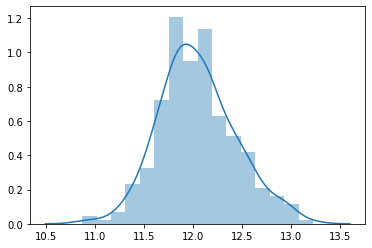

In [163]:
sb.distplot(y_test)

<h3> Normalise train and test data <h>

In [266]:
# #Normalise indipendant variables
from sklearn.preprocessing import StandardScaler

scaler_X=StandardScaler()
X_train_norm=pd.DataFrame(scaler_X.fit_transform(X_train))
X_test_norm=pd.DataFrame(scaler_X.transform(X_test))

# #Normalise response variables
# scaler_Y=StandardScaler()
# y_train_norm=pd.DataFrame(scaler_Y.fit_transform(y_train))
# y_test_norm=pd.DataFrame(scaler_Y.transform(y_test))

# # y_train_log=pd.DataFrame(y_train)
# # y_test_log=pd.DataFrame(y_test)

In [267]:
# # retain column headers after normalization
X_train_norm.columns =X_train.columns
X_test_norm.columns=X_test.columns

# y_train_norm.columns =y_train.columns
# y_test_norm.columns=y_test.columns

<h3> Multiple Linear Regressor<h>

In [166]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [167]:
y_pred=lm.predict(X_test)

In [168]:
residuals = (y_test) - lm.predict(X_test)

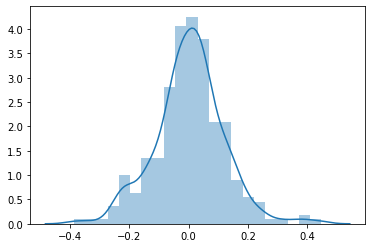

In [169]:
sb.distplot(residuals)

In [170]:
print('Train R^2 is equal to %.3f' %(lm.score(X_train, y_train)))
print('Test R^2 is equal to %.3f' %(lm.score(X_test, y_test)))
print('RSS is equal to %.3f' %(np.sum((residuals)**2)))
print('The intercept is %.3f' %(lm.intercept_))
#print('The slopes are %s' %(lm.coef_))

Train R^2 is equal to 0.895
Test R^2 is equal to 0.910
RSS is equal to 3.994
The intercept is 11.143


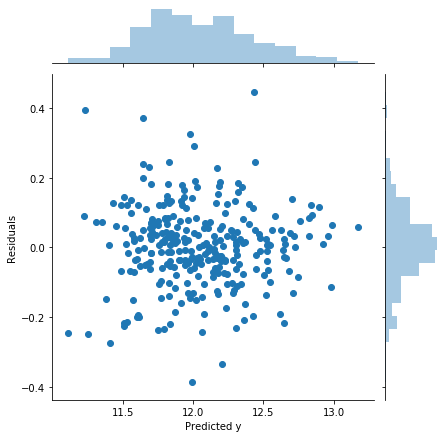

In [171]:
# plot of residuals
g=(sb.jointplot(x=y_pred,y=residuals,).set_axis_labels("Predicted y", "Residuals"))

<h3> Huber Linear Regressor<h>

In [328]:
hr = HuberRegressor()
hr.fit(X_train, y_train)
print("Train R2 is :" ,hr.score(X_train,y_train))
print("Test R2 is :", hr.score(X_test,y_test))

Train R2 is : -20.676980429949882
Test R2 is : -19.834974824198735


/Users/ryernena/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<h3> Feature Evaluation by Ordinary Least Squares <h>


In [197]:
x_sm = sm.add_constant(X_train)
model_sm = sm.OLS(y_train,x_sm)
results_sm = model_sm.fit()
print(results_sm.summary())

                            OLS Regression Results                            
Dep. Variable:          log_saleprice   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     515.8
Date:                Sat, 29 Feb 2020   Prob (F-statistic):               0.00
Time:                        16:09:27   Log-Likelihood:                 736.42
No. Observations:                1164   AIC:                            -1433.
Df Residuals:                    1144   BIC:                            -1332.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               11.1432      0.026  

/Users/ryernena/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [329]:
# Finding predictors - sorted by P values
res=results_sm.pvalues.to_frame()
res=res.reset_index()
res.columns=['X','P_Val']
res.sort_values(by=['P_Val'],ascending=True).head(20)

print('The significant coefficients')
res.loc[res.P_Val < 0.05].sort_values(by='P_Val',ascending=True)

The significant coefficients


,X,P_Val
0,const,0.000000e+00
1,bldg_sf,1.409070e-76
7,adj_ovr_qual,7.030435e-30
6,neg_ovrll_cond,4.751484e-18
4,btm_5_nbrhd,2.787682e-15
2,total_baths,1.901209e-14
18,garagecars,3.431473e-12
10,abnormal_sale,1.088303e-10
8,adj_lot_area,6.533753e-10
3,good_ament_ct,4.620453e-09


<h3> VIF by Statmodel<h>

In [175]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns


vif.sort_values(by='VIF Factor',ascending=True)

,VIF Factor,features
9,1.112988,abnormal_sale
5,1.277422,neg_ovrll_cond
12,1.424852,sgl_famly_hm
13,1.595673,top_3_nbrhd
3,1.954377,btm_5_nbrhd
7,2.042309,adj_lot_area
4,2.368474,newHome
8,2.720225,bad_ament_ct
10,3.007404,outside_sf
15,4.180005,remodelage


<h3> Backward Elimination of Features by using OLS Statmodel API <h>

In [179]:
cols = list(X_train.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
    print(model.summary())

    selected_features_BE = cols
    print("\nOLS Selected Features:\n",selected_features_BE)
print("\nOLS P Values:\n",model.pvalues.sort_values(ascending=True))

                            OLS Regression Results                            
Dep. Variable:          log_saleprice   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     515.8
Date:                Sat, 29 Feb 2020   Prob (F-statistic):               0.00
Time:                        15:35:03   Log-Likelihood:                 736.42
No. Observations:                1164   AIC:                            -1433.
Df Residuals:                    1144   BIC:                            -1332.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               11.1432      0.026  

<h3>Brute Force - Feature Selection of LM Model</h>

In [195]:
from itertools import combinations 
scores = {}
for combo in combinations(X_train.columns, 5):
    lm.fit(X_train[list(combo)], y_train)
    scores[combo] = lm.score(X_train[list(combo)],y_train)

In [194]:
import operator
sorted_d = dict( sorted(scores.items(), key=operator.itemgetter(1),reverse=True))
for k, v in sorted_d.items():
    print(k, v)

('bldg_sf', 'good_ament_ct', 'btm_5_nbrhd', 'neg_ovrll_cond', 'adj_ovr_qual') 0.8586268426420165
('bldg_sf', 'good_ament_ct', 'btm_5_nbrhd', 'adj_ovr_qual', 'garagecars') 0.856952276166267
('bldg_sf', 'total_baths', 'good_ament_ct', 'btm_5_nbrhd', 'adj_ovr_qual') 0.8565132699004575
('bldg_sf', 'good_ament_ct', 'neg_ovrll_cond', 'adj_ovr_qual', 'garagecars') 0.8551311188895764
('bldg_sf', 'good_ament_ct', 'btm_5_nbrhd', 'adj_ovr_qual', 'remodelage') 0.854302551423408
('bldg_sf', 'good_ament_ct', 'btm_5_nbrhd', 'adj_ovr_qual', 'abnormal_sale') 0.8535764382024966
('bldg_sf', 'total_baths', 'btm_5_nbrhd', 'adj_ovr_qual', 'remodelage') 0.8532994324120622
('bldg_sf', 'good_ament_ct', 'btm_5_nbrhd', 'adj_ovr_qual', 'adj_lot_area') 0.85329307142433
('bldg_sf', 'btm_5_nbrhd', 'adj_ovr_qual', 'remodelage', 'garagecars') 0.8531996821674656
('bldg_sf', 'total_baths', 'btm_5_nbrhd', 'neg_ovrll_cond', 'adj_ovr_qual') 0.852869935713013
('bldg_sf', 'total_baths', 'good_ament_ct', 'neg_ovrll_cond', 'ad

('bldg_sf', 'good_ament_ct', 'btm_5_nbrhd', 'top_3_nbrhd', 'bedroomsabvgr') 0.8175165423670245
('bldg_sf', 'good_ament_ct', 'neg_ovrll_cond', 'outside_sf', 'lotfrontage') 0.8175125137414097
('bldg_sf', 'neg_ovrll_cond', 'two_plus_cr_garg', 'homeage', 'garagecars') 0.8174398242824003
('bldg_sf', 'good_ament_ct', 'bad_ament_ct', 'two_plus_cr_garg', 'top_3_nbrhd') 0.8174044060116037
('bldg_sf', 'good_ament_ct', 'adj_lot_area', 'abnormal_sale', 'remodelage') 0.8173961453094097
('bldg_sf', 'good_ament_ct', 'outside_sf', 'top_3_nbrhd', 'garagecars') 0.8173666822968445
('bldg_sf', 'bad_ament_ct', 'two_plus_cr_garg', 'homeage', 'remodelage') 0.8172962049691912
('bldg_sf', 'good_ament_ct', 'abnormal_sale', 'two_plus_cr_garg', 'sgl_famly_hm') 0.8172565198760399
('bldg_sf', 'total_baths', 'good_ament_ct', 'bad_ament_ct', 'sgl_famly_hm') 0.8172388203501135
('bldg_sf', 'adj_ovr_qual', 'two_plus_cr_garg', 'sgl_famly_hm', 'lotfrontage') 0.8172345023568883
('bldg_sf', 'neg_ovrll_cond', 'adj_ovr_qual',

('bldg_sf', 'total_baths', 'btm_5_nbrhd', 'lotfrontage', 'garagecars') 0.7984586532102093
('bldg_sf', 'btm_5_nbrhd', 'outside_sf', 'two_plus_cr_garg', 'homeage') 0.798435089566448
('bldg_sf', 'total_baths', 'two_plus_cr_garg', 'sgl_famly_hm', 'remodelage') 0.7983825400052236
('bldg_sf', 'total_baths', 'newHome', 'bad_ament_ct', 'abnormal_sale') 0.7983570183667817
('bldg_sf', 'neg_ovrll_cond', 'homeage', 'lotfrontage', 'bedroomsabvgr') 0.7983490801380364
('bldg_sf', 'top_3_nbrhd', 'homeage', 'remodelage', 'lotfrontage') 0.7982975116259831
('bldg_sf', 'total_baths', 'two_plus_cr_garg', 'top_3_nbrhd', 'remodelage') 0.7982913042484894
('bldg_sf', 'newHome', 'bad_ament_ct', 'remodelage', 'lotfrontage') 0.7982592378372362
('bldg_sf', 'total_baths', 'newHome', 'sgl_famly_hm', 'homeage') 0.7981987726648341
('bldg_sf', 'btm_5_nbrhd', 'newHome', 'abnormal_sale', 'garagecars') 0.7981714987358726
('bldg_sf', 'newHome', 'top_3_nbrhd', 'homeage', 'remodelage') 0.7981672372085562
('bldg_sf', 'good_am

('bldg_sf', 'btm_5_nbrhd', 'newHome', 'abnormal_sale', 'outside_sf') 0.7811459056683416
('bldg_sf', 'abnormal_sale', 'homeage', 'lotfrontage', 'bedroomsabvgr') 0.7811265156536147
('total_baths', 'neg_ovrll_cond', 'adj_ovr_qual', 'bad_ament_ct', 'outside_sf') 0.781116384582352
('total_baths', 'adj_ovr_qual', 'bad_ament_ct', 'outside_sf', 'bedroomsabvgr') 0.7811159425982517
('total_baths', 'good_ament_ct', 'adj_ovr_qual', 'top_3_nbrhd', 'bedroomsabvgr') 0.7810637476856208
('bldg_sf', 'btm_5_nbrhd', 'neg_ovrll_cond', 'adj_lot_area', 'bad_ament_ct') 0.7810201198324065
('bldg_sf', 'bad_ament_ct', 'lotfrontage', 'garagecars', 'bedroomsabvgr') 0.7809760614809355
('total_baths', 'good_ament_ct', 'newHome', 'adj_ovr_qual', 'sgl_famly_hm') 0.7809708308398978
('total_baths', 'btm_5_nbrhd', 'adj_ovr_qual', 'bad_ament_ct', 'homeage') 0.7809535150780595
('total_baths', 'adj_ovr_qual', 'abnormal_sale', 'remodelage', 'garagecars') 0.7808805650929744
('bldg_sf', 'total_baths', 'bad_ament_ct', 'abnormal

('total_baths', 'adj_ovr_qual', 'abnormal_sale', 'two_plus_cr_garg', 'bedroomsabvgr') 0.7601609451403543
('btm_5_nbrhd', 'adj_ovr_qual', 'adj_lot_area', 'two_plus_cr_garg', 'garagecars') 0.7601569796218614
('good_ament_ct', 'newHome', 'adj_ovr_qual', 'remodelage', 'garagecars') 0.7600717377466298
('good_ament_ct', 'adj_ovr_qual', 'abnormal_sale', 'lotfrontage', 'garagecars') 0.7600346034323744
('good_ament_ct', 'newHome', 'adj_ovr_qual', 'top_3_nbrhd', 'garagecars') 0.7600301831815974
('bldg_sf', 'newHome', 'neg_ovrll_cond', 'lotfrontage', 'bedroomsabvgr') 0.7600224578274466
('btm_5_nbrhd', 'adj_ovr_qual', 'adj_lot_area', 'lotfrontage', 'garagecars') 0.7599622955661738
('good_ament_ct', 'btm_5_nbrhd', 'adj_ovr_qual', 'abnormal_sale', 'two_plus_cr_garg') 0.7599474565485971
('total_baths', 'neg_ovrll_cond', 'adj_ovr_qual', 'two_plus_cr_garg', 'lotfrontage') 0.759910851160515
('good_ament_ct', 'adj_ovr_qual', 'abnormal_sale', 'remodelage', 'garagecars') 0.7598458897739777
('total_baths', 

('btm_5_nbrhd', 'adj_ovr_qual', 'adj_lot_area', 'homeage', 'bedroomsabvgr') 0.7438795656958788
('good_ament_ct', 'newHome', 'adj_ovr_qual', 'bad_ament_ct', 'abnormal_sale') 0.7438266548386794
('bldg_sf', 'neg_ovrll_cond', 'adj_lot_area', 'abnormal_sale', 'bedroomsabvgr') 0.7438216154237994
('adj_ovr_qual', 'adj_lot_area', 'two_plus_cr_garg', 'top_3_nbrhd', 'remodelage') 0.7437490676751607
('adj_ovr_qual', 'bad_ament_ct', 'sgl_famly_hm', 'homeage', 'bedroomsabvgr') 0.7437366526684106
('bldg_sf', 'bad_ament_ct', 'outside_sf', 'top_3_nbrhd', 'lotfrontage') 0.7437306288688802
('good_ament_ct', 'neg_ovrll_cond', 'adj_ovr_qual', 'bad_ament_ct', 'homeage') 0.7437093826782563
('btm_5_nbrhd', 'adj_ovr_qual', 'outside_sf', 'sgl_famly_hm', 'remodelage') 0.743697267121073
('good_ament_ct', 'adj_ovr_qual', 'outside_sf', 'sgl_famly_hm', 'lotfrontage') 0.7436805839411114
('btm_5_nbrhd', 'adj_ovr_qual', 'bad_ament_ct', 'abnormal_sale', 'bedroomsabvgr') 0.7436789985777746
('bldg_sf', 'outside_sf', 'two

('adj_ovr_qual', 'adj_lot_area', 'abnormal_sale', 'homeage', 'lotfrontage') 0.7216832241566951
('total_baths', 'good_ament_ct', 'adj_lot_area', 'bad_ament_ct', 'top_3_nbrhd') 0.721633512026124
('total_baths', 'good_ament_ct', 'neg_ovrll_cond', 'sgl_famly_hm', 'top_3_nbrhd') 0.7216219851471503
('good_ament_ct', 'adj_lot_area', 'abnormal_sale', 'outside_sf', 'garagecars') 0.7215938015438929
('good_ament_ct', 'btm_5_nbrhd', 'two_plus_cr_garg', 'top_3_nbrhd', 'bedroomsabvgr') 0.7215651336239022
('adj_ovr_qual', 'sgl_famly_hm', 'top_3_nbrhd', 'remodelage', 'bedroomsabvgr') 0.7215241129012877
('good_ament_ct', 'btm_5_nbrhd', 'neg_ovrll_cond', 'bad_ament_ct', 'garagecars') 0.7215183981803678
('good_ament_ct', 'top_3_nbrhd', 'lotfrontage', 'garagecars', 'bedroomsabvgr') 0.7214882319034902
('adj_ovr_qual', 'adj_lot_area', 'outside_sf', 'lotfrontage', 'bedroomsabvgr') 0.7213950314290851
('btm_5_nbrhd', 'newHome', 'neg_ovrll_cond', 'adj_ovr_qual', 'two_plus_cr_garg') 0.7213179786099702
('newHome'

('good_ament_ct', 'abnormal_sale', 'sgl_famly_hm', 'homeage', 'garagecars') 0.6958975292323338
('adj_ovr_qual', 'abnormal_sale', 'sgl_famly_hm', 'remodelage', 'lotfrontage') 0.6958914004770071
('good_ament_ct', 'neg_ovrll_cond', 'adj_lot_area', 'two_plus_cr_garg', 'top_3_nbrhd') 0.6958757538706091
('newHome', 'neg_ovrll_cond', 'adj_ovr_qual', 'top_3_nbrhd', 'homeage') 0.6957983435570094
('good_ament_ct', 'btm_5_nbrhd', 'outside_sf', 'two_plus_cr_garg', 'sgl_famly_hm') 0.6957873248983064
('total_baths', 'good_ament_ct', 'abnormal_sale', 'homeage', 'bedroomsabvgr') 0.6957470707360501
('newHome', 'adj_ovr_qual', 'abnormal_sale', 'homeage', 'remodelage') 0.6957425875854519
('newHome', 'adj_ovr_qual', 'abnormal_sale', 'top_3_nbrhd', 'remodelage') 0.695712998574654
('good_ament_ct', 'btm_5_nbrhd', 'outside_sf', 'sgl_famly_hm', 'bedroomsabvgr') 0.6956903357831725
('adj_ovr_qual', 'sgl_famly_hm', 'top_3_nbrhd', 'lotfrontage', 'bedroomsabvgr') 0.695678359014178
('bldg_sf', 'sgl_famly_hm', 'top_

('good_ament_ct', 'bad_ament_ct', 'sgl_famly_hm', 'top_3_nbrhd', 'homeage') 0.6727524837953612
('good_ament_ct', 'btm_5_nbrhd', 'sgl_famly_hm', 'lotfrontage', 'bedroomsabvgr') 0.6727311004789445
('total_baths', 'two_plus_cr_garg', 'top_3_nbrhd', 'garagecars', 'bedroomsabvgr') 0.6726998313047938
('good_ament_ct', 'neg_ovrll_cond', 'bad_ament_ct', 'outside_sf', 'homeage') 0.6725775560966204
('bad_ament_ct', 'outside_sf', 'two_plus_cr_garg', 'remodelage', 'garagecars') 0.6725578837452592
('total_baths', 'newHome', 'neg_ovrll_cond', 'abnormal_sale', 'garagecars') 0.6725232406660315
('good_ament_ct', 'neg_ovrll_cond', 'homeage', 'lotfrontage', 'bedroomsabvgr') 0.6725067620783434
('good_ament_ct', 'btm_5_nbrhd', 'adj_lot_area', 'bad_ament_ct', 'sgl_famly_hm') 0.6724791017629601
('good_ament_ct', 'neg_ovrll_cond', 'two_plus_cr_garg', 'top_3_nbrhd', 'remodelage') 0.6724762863580134
('total_baths', 'neg_ovrll_cond', 'two_plus_cr_garg', 'lotfrontage', 'garagecars') 0.6724405418863718
('good_amen

('adj_lot_area', 'bad_ament_ct', 'two_plus_cr_garg', 'top_3_nbrhd', 'remodelage') 0.6490127269262556
('neg_ovrll_cond', 'outside_sf', 'homeage', 'garagecars', 'bedroomsabvgr') 0.64892029332227
('bad_ament_ct', 'abnormal_sale', 'two_plus_cr_garg', 'remodelage', 'garagecars') 0.6488334203674456
('total_baths', 'outside_sf', 'two_plus_cr_garg', 'top_3_nbrhd', 'homeage') 0.6488228316905393
('btm_5_nbrhd', 'newHome', 'outside_sf', 'top_3_nbrhd', 'garagecars') 0.6487736145579919
('good_ament_ct', 'adj_lot_area', 'homeage', 'remodelage', 'lotfrontage') 0.648719927726354
('good_ament_ct', 'outside_sf', 'top_3_nbrhd', 'remodelage', 'lotfrontage') 0.6486814440100199
('total_baths', 'abnormal_sale', 'two_plus_cr_garg', 'lotfrontage', 'garagecars') 0.6486753165580347
('total_baths', 'neg_ovrll_cond', 'outside_sf', 'top_3_nbrhd', 'homeage') 0.6486679658180852
('newHome', 'bad_ament_ct', 'outside_sf', 'sgl_famly_hm', 'garagecars') 0.6486445672444359
('good_ament_ct', 'btm_5_nbrhd', 'neg_ovrll_cond',

('abnormal_sale', 'top_3_nbrhd', 'homeage', 'remodelage', 'garagecars') 0.6217971067232282
('btm_5_nbrhd', 'newHome', 'neg_ovrll_cond', 'top_3_nbrhd', 'garagecars') 0.621672117525609
('total_baths', 'newHome', 'outside_sf', 'two_plus_cr_garg', 'homeage') 0.6215187669769164
('total_baths', 'newHome', 'top_3_nbrhd', 'homeage', 'remodelage') 0.6212869139809569
('good_ament_ct', 'neg_ovrll_cond', 'abnormal_sale', 'homeage', 'remodelage') 0.6212037754586021
('total_baths', 'newHome', 'neg_ovrll_cond', 'abnormal_sale', 'top_3_nbrhd') 0.621131428066774
('total_baths', 'btm_5_nbrhd', 'neg_ovrll_cond', 'adj_lot_area', 'remodelage') 0.6210957989027164
('neg_ovrll_cond', 'bad_ament_ct', 'lotfrontage', 'garagecars', 'bedroomsabvgr') 0.6210194289820011
('btm_5_nbrhd', 'adj_lot_area', 'bad_ament_ct', 'sgl_famly_hm', 'garagecars') 0.6210086563997728
('total_baths', 'btm_5_nbrhd', 'sgl_famly_hm', 'remodelage', 'bedroomsabvgr') 0.6209884479884749
('btm_5_nbrhd', 'neg_ovrll_cond', 'outside_sf', 'lotfron

('total_baths', 'neg_ovrll_cond', 'two_plus_cr_garg', 'sgl_famly_hm', 'lotfrontage') 0.5948675116546664
('btm_5_nbrhd', 'neg_ovrll_cond', 'outside_sf', 'top_3_nbrhd', 'remodelage') 0.5948279115851159
('newHome', 'bad_ament_ct', 'two_plus_cr_garg', 'sgl_famly_hm', 'remodelage') 0.5947947201802497
('abnormal_sale', 'outside_sf', 'top_3_nbrhd', 'lotfrontage', 'garagecars') 0.5947409168399573
('newHome', 'outside_sf', 'two_plus_cr_garg', 'top_3_nbrhd', 'remodelage') 0.5947093629728124
('total_baths', 'neg_ovrll_cond', 'bad_ament_ct', 'abnormal_sale', 'bedroomsabvgr') 0.5946806628061021
('total_baths', 'abnormal_sale', 'two_plus_cr_garg', 'remodelage', 'lotfrontage') 0.594592312710535
('btm_5_nbrhd', 'newHome', 'bad_ament_ct', 'two_plus_cr_garg', 'bedroomsabvgr') 0.5944707716268275
('bad_ament_ct', 'outside_sf', 'homeage', 'lotfrontage', 'bedroomsabvgr') 0.5944162520278282
('total_baths', 'adj_lot_area', 'sgl_famly_hm', 'remodelage', 'lotfrontage') 0.5943824745579518
('neg_ovrll_cond', 'adj

('btm_5_nbrhd', 'newHome', 'bad_ament_ct', 'homeage', 'bedroomsabvgr') 0.5602057370190998
('btm_5_nbrhd', 'newHome', 'two_plus_cr_garg', 'remodelage', 'bedroomsabvgr') 0.5601436509485342
('btm_5_nbrhd', 'neg_ovrll_cond', 'adj_lot_area', 'bad_ament_ct', 'remodelage') 0.5601425216234601
('total_baths', 'adj_lot_area', 'top_3_nbrhd', 'lotfrontage', 'bedroomsabvgr') 0.5600449090673715
('newHome', 'abnormal_sale', 'top_3_nbrhd', 'lotfrontage', 'garagecars') 0.5600203079815049
('neg_ovrll_cond', 'outside_sf', 'two_plus_cr_garg', 'top_3_nbrhd', 'lotfrontage') 0.5599608625422943
('newHome', 'neg_ovrll_cond', 'bad_ament_ct', 'sgl_famly_hm', 'top_3_nbrhd') 0.5598901445179935
('newHome', 'outside_sf', 'top_3_nbrhd', 'remodelage', 'bedroomsabvgr') 0.5598390718662731
('neg_ovrll_cond', 'adj_lot_area', 'outside_sf', 'two_plus_cr_garg', 'remodelage') 0.5597875141483653
('newHome', 'adj_lot_area', 'bad_ament_ct', 'remodelage', 'lotfrontage') 0.5597205690242278
('total_baths', 'abnormal_sale', 'top_3_n

('adj_lot_area', 'abnormal_sale', 'top_3_nbrhd', 'remodelage', 'lotfrontage') 0.4983713190681797
('btm_5_nbrhd', 'adj_lot_area', 'two_plus_cr_garg', 'homeage', 'lotfrontage') 0.4982993512865904
('btm_5_nbrhd', 'newHome', 'adj_lot_area', 'abnormal_sale', 'outside_sf') 0.49803238131450467
('abnormal_sale', 'sgl_famly_hm', 'top_3_nbrhd', 'homeage', 'lotfrontage') 0.4980198109108905
('btm_5_nbrhd', 'newHome', 'neg_ovrll_cond', 'outside_sf', 'lotfrontage') 0.4980145764307289
('neg_ovrll_cond', 'two_plus_cr_garg', 'sgl_famly_hm', 'homeage', 'lotfrontage') 0.49793774987597883
('btm_5_nbrhd', 'newHome', 'neg_ovrll_cond', 'adj_lot_area', 'remodelage') 0.4978846803440697
('btm_5_nbrhd', 'newHome', 'adj_lot_area', 'two_plus_cr_garg', 'sgl_famly_hm') 0.49778344057059776
('newHome', 'two_plus_cr_garg', 'homeage', 'remodelage', 'lotfrontage') 0.4972647477800434
('newHome', 'outside_sf', 'sgl_famly_hm', 'remodelage', 'bedroomsabvgr') 0.49723564917975693
('newHome', 'adj_lot_area', 'bad_ament_ct', 'ab

<h3> Lasso Regressor <h>

In [305]:
# using normalized predictor variables
lasso = Lasso()
train_lasso_R2 = []
test_lasso_R2  = []
alphaRange = np.linspace(1e-3,20,20)
for alpha in alphaRange:
          lasso.set_params(alpha=alpha, normalize=False, max_iter=2000)
          lasso.fit(X_train,y_train)
          train_lasso_R2.append(lasso.score(X_train,y_train))
          test_lasso_R2.append(lasso.score(X_test,y_test))

Mean RSquare of Lasso Reg on Train set:  0.691191944131727
Mean RSquare of Lasso Reg on Test set:  0.7250247097573939


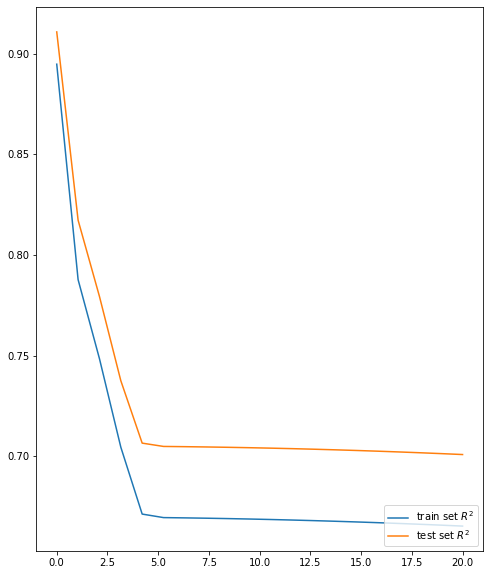

In [306]:
plt.plot(alphaRange, train_lasso_R2, label=r'train set $R^2$')
plt.plot(alphaRange, test_lasso_R2, label=r'test set $R^2$')
plt.legend(loc=4)

print("Mean RSquare of Lasso Reg on Train set: ", np.mean(train_lasso_R2))
print("Mean RSquare of Lasso Reg on Test set: ", np.mean(test_lasso_R2))

In [307]:
# Lasso with various lambda on full data
coefs_lasso = []
intercepts_lasso= []
R2_lasso  = []
alphaRange = np.linspace(1e-3,1,20)
for alpha in alphaRange:
            lasso.set_params(alpha=alpha, normalize = False,max_iter=2000)  
            lasso.fit(X_train, y_train)
            intercepts_lasso.append(lasso.intercept_)
            coefs_lasso.append(lasso.coef_)
            R2_lasso.append(lasso.score(X_train,y_train))

Text(0.5, 1.0, 'Change of Lasso Slopes Varying Alpha')

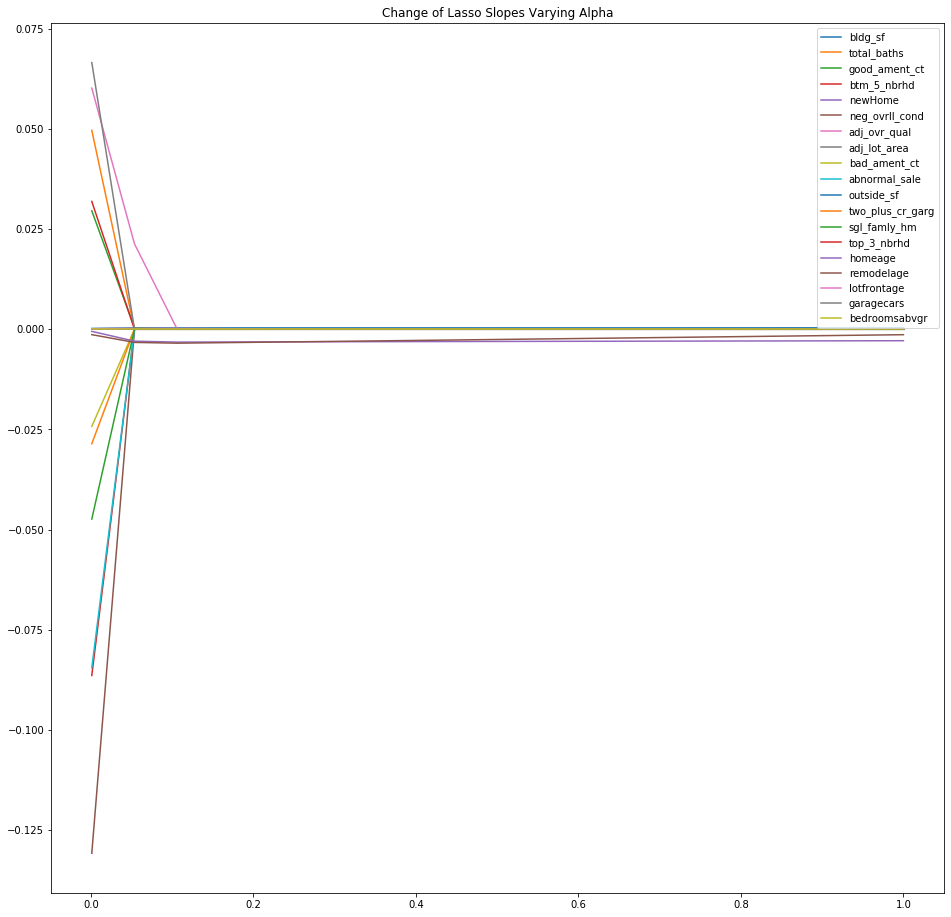

In [308]:
coefs_df = pd.DataFrame(np.array(coefs_lasso), columns=X_train.columns)

plt.figure(figsize=(16,16))


for name in coefs_df.columns:
    plt.plot(alphaRange, coefs_df[name], label=name)
plt.legend(loc=1)    
plt.title('Change of Lasso Slopes Varying Alpha')

In [309]:
coef_sr = pd.Series(lasso.coef_, index=X_train.columns)
print("Lasso picked " + str(sum(coef_sr != 0)) + " variables and eliminated the other " +  str(sum(coef_sr == 0)) + " variables")

Lasso picked 5 variables and eliminated the other 14 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

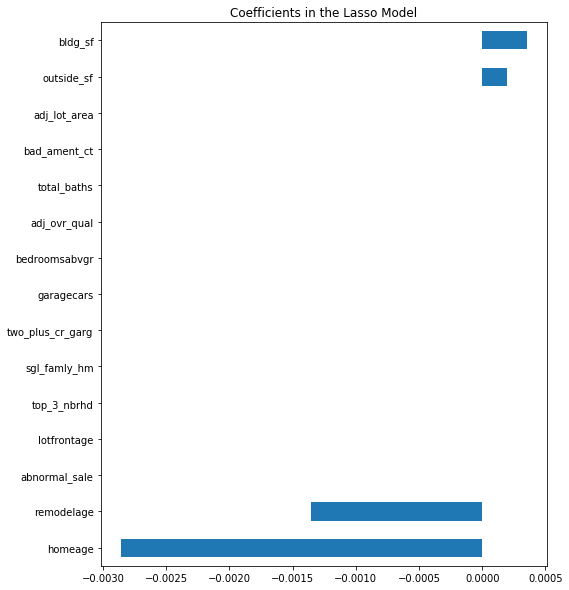

In [316]:
imp_coef = pd.concat([coef_sr.sort_values().head(10),
                     coef_sr.sort_values().tail(5)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

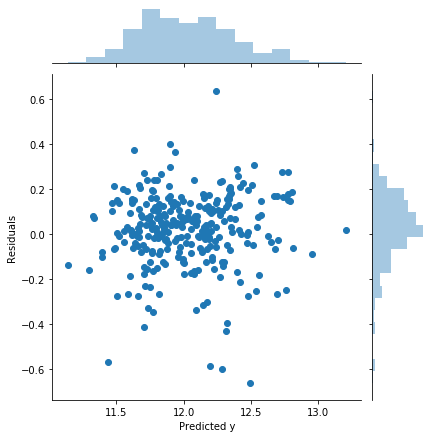

In [317]:
# plot of residuals
y_pred=lasso.predict(X_test)
lasso_residuals = y_test['log_saleprice']-y_pred
g=(sb.jointplot(x=y_pred,y=lasso_residuals).set_axis_labels("Predicted y", "Residuals"))

In [318]:
#LassoCV Cross Validation
regLassoCV = LassoCV(cv=10, alphas=np.linspace(1e-3,1,20),max_iter=2000, normalize=False,random_state=0).fit(X, y)
print("R-Square :", regLassoCV.score(X_train, y_train))

R-Square : 0.8941437984171099


/Users/ryernena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [322]:
# Applying k-Fold Cross Validation on train/test split
lasso.set_params(alpha=1, normalize=False)
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = lasso, X = X_train, y = y_train, cv = 10)
print(accuracies.mean())
accuracies

0.7815853297771649


array([0.8042251 , 0.80954434, 0.72713837, 0.74130202, 0.81833342,
       0.84157132, 0.67391496, 0.84632175, 0.77499294, 0.77850907])

<h3> Feature Importance by Randomn Forest Regressor <h>

/Users/ryernena/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


<Figure size 1152x1152 with 0 Axes>

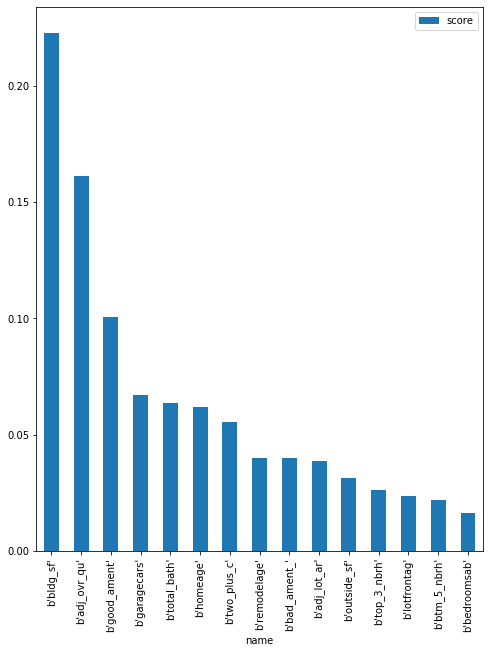

In [324]:
from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor()

randomForest.set_params(random_state=42, n_estimators=100, max_features=3)
randomForest.fit(X_train,y_train) # fit 
randomForest.score(X_train,y_train) # accuracy

feature_importance = list(zip(X_train.columns, randomForest.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
plt.figure(figsize=(16,16))
pd.DataFrame({'name':name,'score':score})[:15].plot.bar(x='name', y='score')

<h3> XGBoost Regressor <h>

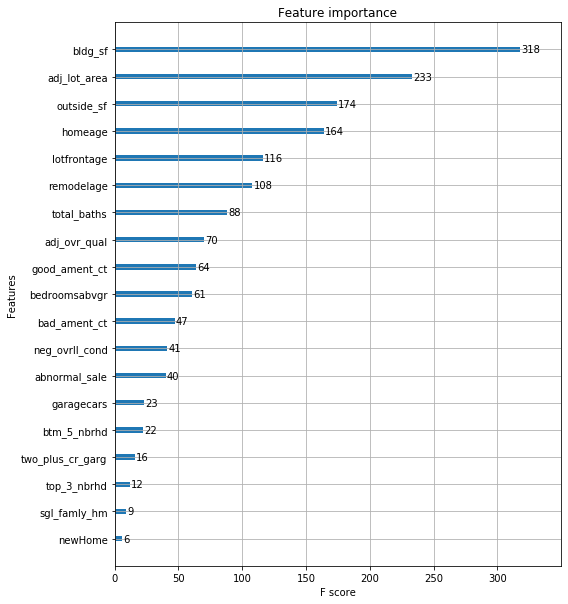

In [327]:
# Fitting XGBoost Regressor
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error

xgbr = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.1,
                            max_depth = 5)
xgbr.fit(X_train,y_train)

# Predicting the Test set results
y_pred = xgbr.predict(X_test)


plot_importance(xgbr)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()